In [1]:
from pathlib import Path
import sys, os

scriptPath = Path(sys.path[0])
parentPath = scriptPath.parent
dataPath = parentPath / 'data'
srcPath = parentPath / 'src'
modelPath = parentPath / 'models'
savePath = parentPath / 'results'
plotPath = parentPath / 'plots'
miscPath = parentPath / 'misc'

sys.path.append(srcPath.as_posix())

In [2]:
import torch
from torchvision import datasets, transforms

test_batch_size = 100
image_size = 28

# Dataset
testset = datasets.MNIST(dataPath, train=False, download=True,
                        transform=transforms.Compose([
                        transforms.Resize(image_size),
                        transforms.ToTensor()
                   ]))
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False)

for i, (data, target) in enumerate(test_loader):
    test_input_i, test_labels_i = data, target
    break

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def format_pivot(results_df_pivot):
    """
    Helper function to format the DataFrame to show the results"""
    # Move K→∞ to the last column
    cols = results_df_pivot.columns.tolist()
    if 0 in cols:
        cols = [col for col in cols if col != 0] + [0]
    results_df_pivot = results_df_pivot[cols]

    def print_K(K):
        if K==0:
            return '$K\rightarrow \infty$'
        else:
            return f'$K={K}$'

    # Update index name
    try: 
        results_df_pivot.index[0][0]
        # The index is subscriptable (list or tuple)
        results_df_pivot.index = [f"784-{'-'.join([str(n) for n in nh])}-10" for nh in results_df_pivot.index]
    except:
        # The index is NOT subscriptable (number)
        results_df_pivot.index = [f"784-{nh}-10" for nh in results_df_pivot.index]
    results_df_pivot.columns = [print_K(k) for k in results_df_pivot.columns]
    
    return results_df_pivot

# Coherent SPDNNs

In [5]:
from SPDNN_MLP import coh_PDMLP as MLP

coh_models = {}
coh_Ns = []
for f in os.listdir(modelPath):
    if f.startswith(f'MNIST{image_size}x{image_size}_coh') and f.endswith('].pth'):
        N = tuple([int(num) for num in f.split('_N[')[1].split(']')[0].split(',')])
        coh_Ns.append(N)
        print(N,f)

        model = MLP(n_hiddens=N,n_input=image_size**2,n_output=10)

        model.load_state_dict(torch.load(modelPath / f, map_location=device))
        model.to(device)
        model.eval()
        coh_models[N] = model

coh_Ns.sort()
coh_Ns

(30,) MNIST28x28_coh_N[30].pth
(50,) MNIST28x28_coh_N[50].pth
(20,) MNIST28x28_coh_N[20].pth
(400,) MNIST28x28_coh_N[400].pth
(100,) MNIST28x28_coh_N[100].pth
(400, 400) MNIST28x28_coh_N[400,400].pth
(10,) MNIST28x28_coh_N[10].pth
(200,) MNIST28x28_coh_N[200].pth
(25,) MNIST28x28_coh_N[25].pth


[(10,), (20,), (25,), (30,), (50,), (100,), (200,), (400,), (400, 400)]

In [6]:
from SPDNN_Conv import PDConvNet

nc = [16]
ss = [1]
kss = [5]
batch_norm = False
last_layer_bias = True
for f in os.listdir(modelPath):
    if f.startswith('MNIST28x28_conv16'):
        N = ('C16',400)
        coh_Ns.append(N)
        print(N,f)

        model = PDConvNet(n_linear=400,n_output=10,n_chan=nc,ss=ss,kss=kss,batchnorm=batch_norm,last_layer_bias=last_layer_bias)

        model.load_state_dict(torch.load(modelPath / f, map_location=device))
        model.to(device)
        model.eval()
        coh_models[N] = model

coh_Ns

('C16', 400) MNIST28x28_conv16.pth


[(10,),
 (20,),
 (25,),
 (30,),
 (50,),
 (100,),
 (200,),
 (400,),
 (400, 400),
 ('C16', 400)]

In [7]:
%%time
import pandas as pd
import numpy as np
import torch

# create a DataFrame for the results
coh_results_df = pd.DataFrame(columns=['N', 'K', 'mean_accuracy', 'std_dev'])
torch.manual_seed(0)

nr = 100
Ks = np.r_[1,2,3,5,7,10,0]

temp_results = []

for N in coh_Ns:
    print(N)
    for Ki, K in enumerate(Ks):
        acc_arr = np.zeros((len(Ks),nr))
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            
            for j in range(nr):
                output = coh_models[N](data,n_rep=K)
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct = pred.eq(target.data.view_as(pred)).cpu().sum()
                acc_arr[Ki,j] += correct

        acc_arr = acc_arr / float(len(testset))
        mean_acc = 100. * acc_arr[Ki].mean()
        std_dev = 100. * acc_arr[Ki].std()

        # append the results to a DataFrame
        temp_results.append({'N': N, 'K': int(K), 'mean_accuracy': mean_acc, 'std_dev': std_dev})

coh_results_df = pd.concat([pd.DataFrame([i]) for i in temp_results], ignore_index=True)

# Pivot the DataFrame so that 'K' are columns and 'N' are rows with 'mean_accuracy' and 'std_dev' together in the same cell
coh_results_df['results'] = coh_results_df.apply(lambda row: f"{np.round(row['mean_accuracy'],2):.2f} ± {np.round(row['std_dev'],2):.2f}%", axis=1)


(10,)
(20,)
(25,)
(30,)
(50,)
(100,)
(200,)
(400,)
(400, 400)
('C16', 400)
CPU times: user 11min 5s, sys: 2min 2s, total: 13min 8s
Wall time: 13min 7s


In [8]:
coh_results_df_pivot = format_pivot(coh_results_df.pivot(index='N', columns='K', values='results'))

coh_results_df_pivot

,$K=1$,$K=2$,$K=3$,$K=5$,$K=7$,$K=10$,$K\rightarrow \infty$
784-10-10,80.21 ± 0.27%,85.63 ± 0.24%,87.49 ± 0.19%,88.85 ± 0.15%,89.42 ± 0.15%,89.87 ± 0.14%,90.70 ± 0.00%
784-20-10,89.31 ± 0.23%,92.43 ± 0.17%,93.42 ± 0.14%,94.10 ± 0.13%,94.39 ± 0.14%,94.60 ± 0.11%,95.05 ± 0.00%
784-25-10,91.51 ± 0.20%,94.16 ± 0.16%,94.89 ± 0.14%,95.47 ± 0.12%,95.70 ± 0.10%,95.86 ± 0.08%,96.10 ± 0.00%
784-30-10,92.72 ± 0.19%,94.92 ± 0.13%,95.58 ± 0.12%,96.05 ± 0.10%,96.26 ± 0.09%,96.41 ± 0.08%,96.74 ± 0.00%
784-50-10,95.50 ± 0.15%,96.88 ± 0.11%,97.26 ± 0.09%,97.55 ± 0.08%,97.67 ± 0.07%,97.77 ± 0.07%,97.93 ± 0.00%
784-100-10,97.41 ± 0.13%,98.16 ± 0.08%,98.36 ± 0.08%,98.52 ± 0.07%,98.58 ± 0.06%,98.61 ± 0.05%,98.70 ± 0.00%
784-200-10,98.34 ± 0.10%,98.76 ± 0.07%,98.88 ± 0.07%,98.97 ± 0.05%,99.00 ± 0.05%,99.04 ± 0.04%,99.12 ± 0.00%
784-400-400-10,98.95 ± 0.08%,99.21 ± 0.05%,99.29 ± 0.04%,99.33 ± 0.04%,99.35 ± 0.04%,99.37 ± 0.03%,99.40 ± 0.00%
784-400-10,98.64 ± 0.08%,98.95 ± 0.06%,99.04 ± 0.05%,99.09 ± 0.05%,99.12 ± 0.04%,99.14 ± 0.03%,99.19 ± 0.00%
784-C16-400-10,99.33 ± 0.05%,99.44 ± 0.04%,99.48 ± 0.04%,99.50 ± 0.03%,99.51 ± 0.03%,99.52 ± 0.03%,99.54 ± 0.00%


In [9]:
coh_results_df.to_pickle(savePath / 'MNIST_coh_simacc')
coh_results = coh_results_df

In [6]:
import pandas
coh_results = pandas.read_pickle(savePath / 'MNIST_coh_simacc')

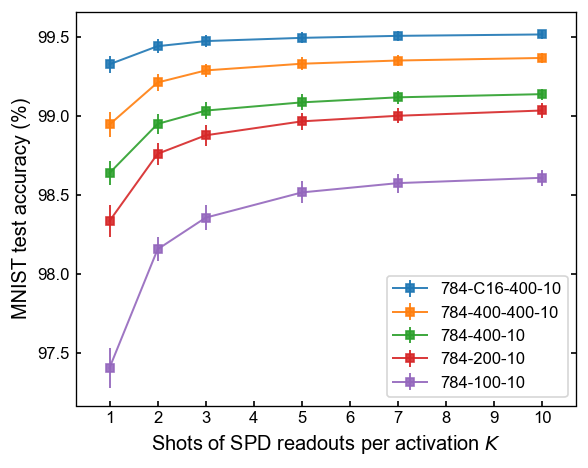

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use(miscPath / 'plot.mplstyle')

common_kwg = {'lw':1.2, 'capsize':0,'alpha':0.9}
fig, ax = plt.subplots(figsize=(5,4),dpi=120)
nns = coh_results['K'].unique()
nns = nns[nns!=0]
ids = np.arange(nns.shape[0])

for N in coh_results['N'].unique()[5:][::-1]:
    means = coh_results.loc[coh_results['N']==N]['mean_accuracy'].values
    stds = coh_results.loc[coh_results['N']==N]['std_dev'].values
    plt.errorbar(nns[ids],means[ids],yerr=stds[ids],fmt='s-',ms=5, label=f"784-{'-'.join([str(n) for n in N])}-10",**common_kwg)

plt.xlabel(r'Shots of SPD readouts per activation $K$')
plt.ylabel('MNIST test accuracy (%)')

# plt.grid()
plt.xticks(np.arange(11))
plt.xlim(0.3,10.7)
plt.legend()
plt.tight_layout()
plt.savefig(plotPath / 'mnist_coh_sim.png')

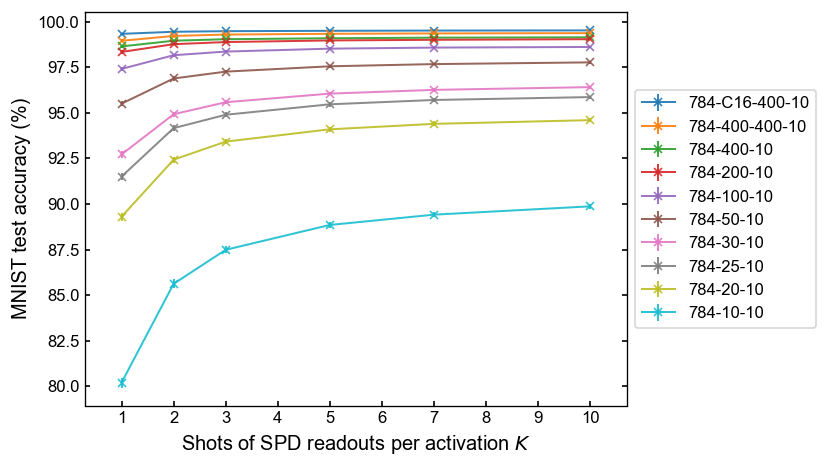

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use(miscPath / 'plot.mplstyle')

common_kwg = {'lw':1.2, 'capsize':0,'alpha':0.9}
fig, ax = plt.subplots(figsize=(7,4),dpi=120)
nns = coh_results['K'].unique()
nns = nns[nns!=0]
ids = np.arange(nns.shape[0])

for N in coh_results['N'].unique()[::-1]:
    means = coh_results.loc[coh_results['N']==N]['mean_accuracy'].values
    stds = coh_results.loc[coh_results['N']==N]['std_dev'].values
    plt.errorbar(nns[ids],means[ids],yerr=stds[ids],fmt='x-',ms=5, label=f"784-{'-'.join([str(n) for n in N])}-10",**common_kwg)

plt.xlabel(r'Shots of SPD readouts per activation $K$')
plt.ylabel('MNIST test accuracy (%)')

# plt.grid()
plt.xticks(np.arange(11))
plt.xlim(0.3,10.7)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(plotPath / 'mnist_coh_sim_all.png')

# Incoherent SPDNNs

In [5]:
from SPDNN_MLP import PDMLP_1 as MLP

incoh_models = {}
incoh_Ns = []
for f in os.listdir(modelPath):
    if f.startswith(f'MNIST{image_size}x{image_size}_incoh'):
        N = int(f.split('_')[2][1:].split('.')[0])
        incoh_Ns.append(N)
        print(N,f)

        model = MLP(n_hidden=N,n_input=image_size**2,n_output=10,last_layer_bias=True)

        model.load_state_dict(torch.load(modelPath / f, map_location=device))
        model.to(device)
        model.eval()
        incoh_models[N] = model

incoh_Ns.sort()
incoh_Ns

100 MNIST28x28_incoh_N100.pth
400 MNIST28x28_incoh_N400.pth
20 MNIST28x28_incoh_N20.pth
300 MNIST28x28_incoh_N300.pth
200 MNIST28x28_incoh_N200.pth
10 MNIST28x28_incoh_N10.pth
50 MNIST28x28_incoh_N50.pth


[10, 20, 50, 100, 200, 300, 400]

In [6]:
%%time
import pandas as pd
import numpy as np
import torch

# create a DataFrame for the results
incoh_results_df = pd.DataFrame(columns=['N', 'K', 'mean_accuracy', 'std_dev'])
torch.manual_seed(0)

nr = 100
Ks = np.r_[1,2,3,5,7,10,0]

temp_results = []

for N in incoh_Ns:
    for Ki, K in enumerate(Ks):
        acc_arr = np.zeros((len(Ks),nr))
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            
            for j in range(nr):
                output = incoh_models[N](data,n_rep=K)
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct = pred.eq(target.data.view_as(pred)).cpu().sum()
                acc_arr[Ki,j] += correct

        acc_arr = acc_arr / float(len(testset))
        mean_acc = 100. * acc_arr[Ki].mean()
        std_dev = 100. * acc_arr[Ki].std()

        # append the results to a DataFrame
        temp_results.append({'N': int(N), 'K': int(K), 'mean_accuracy': mean_acc, 'std_dev': std_dev})

incoh_results_df = pd.concat([pd.DataFrame([i]) for i in temp_results], ignore_index=True)

incoh_results_df['N'] = incoh_results_df['N'].astype(int)
incoh_results_df['K'] = incoh_results_df['K'].astype(int)


# Pivot the DataFrame so that 'K' are columns and 'N' are rows with 'mean_accuracy' and 'std_dev' together in the same cell
incoh_results_df['results'] = incoh_results_df.apply(lambda row: \
                    f"{np.round(row['mean_accuracy'],2):.2f} ± {np.round(row['std_dev'],2):.2f}%", axis=1)


CPU times: user 11min 57s, sys: 3min 39s, total: 15min 37s
Wall time: 15min 57s


In [7]:
incoh_results_df_pivot = format_pivot(incoh_results_df.pivot(index='N', columns='K', values='results'))

incoh_results_df_pivot

,$K=1$,$K=2$,$K=3$,$K=5$,$K=7$,$K=10$,$K\rightarrow \infty$
784-10-10,78.03 ± 0.32%,83.18 ± 0.26%,84.79 ± 0.22%,86.13 ± 0.17%,86.65 ± 0.17%,87.08 ± 0.16%,87.91 ± 0.00%
784-20-10,86.74 ± 0.24%,89.98 ± 0.18%,90.96 ± 0.15%,91.71 ± 0.13%,92.00 ± 0.13%,92.22 ± 0.13%,92.66 ± 0.00%
784-50-10,93.04 ± 0.16%,94.49 ± 0.15%,94.92 ± 0.12%,95.24 ± 0.11%,95.38 ± 0.10%,95.47 ± 0.09%,95.73 ± 0.00%
784-100-10,95.20 ± 0.16%,96.24 ± 0.11%,96.53 ± 0.10%,96.75 ± 0.09%,96.85 ± 0.07%,96.91 ± 0.07%,97.02 ± 0.00%
784-200-10,96.62 ± 0.12%,97.33 ± 0.10%,97.54 ± 0.08%,97.70 ± 0.08%,97.75 ± 0.08%,97.80 ± 0.06%,97.98 ± 0.00%
784-300-10,97.00 ± 0.12%,97.61 ± 0.08%,97.80 ± 0.08%,97.93 ± 0.07%,97.97 ± 0.06%,98.01 ± 0.05%,98.12 ± 0.00%
784-400-10,97.31 ± 0.11%,97.85 ± 0.10%,98.01 ± 0.09%,98.15 ± 0.06%,98.20 ± 0.06%,98.27 ± 0.05%,98.41 ± 0.00%


In [8]:
incoh_results_df.to_pickle(savePath / 'MNIST_incoh_simacc')
incoh_results = incoh_results_df

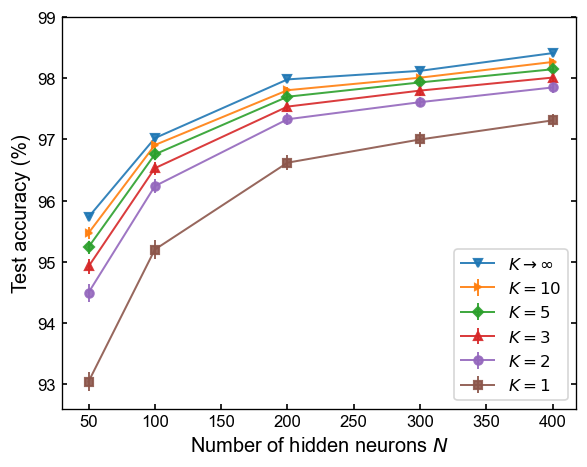

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use(miscPath / 'plot.mplstyle')

common_kwg = {'lw':1.2,'markeredgewidth':1.3,'alpha':.9,'capsize': 0}
fig, ax = plt.subplots(figsize=(5,4),dpi=120)
nns = incoh_results['N'].unique()
ids = np.arange(nns.shape[0])[2:]

K = 0
means = incoh_results.loc[incoh_results['K']==K]['mean_accuracy'].values
stds = incoh_results.loc[incoh_results['K']==K]['std_dev'].values
plt.errorbar(nns[ids],means[ids],fmt='v-',ms=5,label=r'$K \rightarrow \infty$',**common_kwg)

K = 10
means = incoh_results.loc[incoh_results['K']==K]['mean_accuracy'].values
stds = incoh_results.loc[incoh_results['K']==K]['std_dev'].values
plt.errorbar(nns[ids],means[ids],yerr=stds[ids],fmt='>-',ms=4,label=r'$K={}$'.format(K),**common_kwg)

K = 5
means = incoh_results.loc[incoh_results['K']==K]['mean_accuracy'].values
stds = incoh_results.loc[incoh_results['K']==K]['std_dev'].values
plt.errorbar(nns[ids],means[ids],yerr=stds[ids],fmt='D-',ms=4,label=r'$K={}$'.format(K),**common_kwg)

K = 3
means = incoh_results.loc[incoh_results['K']==K]['mean_accuracy'].values
stds = incoh_results.loc[incoh_results['K']==K]['std_dev'].values
plt.errorbar(nns[ids],means[ids],yerr=stds[ids],fmt='^-',ms=5,label=r'$K={}$'.format(K),**common_kwg)

K = 2
means = incoh_results.loc[incoh_results['K']==K]['mean_accuracy'].values
stds = incoh_results.loc[incoh_results['K']==K]['std_dev'].values
plt.errorbar(nns[ids],means[ids],yerr=stds[ids],fmt='o-',ms=5,label=r'$K={}$'.format(K),**common_kwg)

K = 1
means = incoh_results.loc[incoh_results['K']==K]['mean_accuracy'].values
stds = incoh_results.loc[incoh_results['K']==K]['std_dev'].values
plt.errorbar(nns[ids],means[ids],yerr=stds[ids],fmt='s-',ms=4.5,label=r'$K={}$'.format(K),**common_kwg)

plt.xlabel(f'Number of hidden neurons $N$')
plt.ylabel('Test accuracy (%)')

plt.ylim(92.6,99.)
plt.xlim(30)
plt.xticks(np.arange(50,444,50))
plt.yticks(range(93,100))
# plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(plotPath / 'mnist_incoh_sim.png')